# ALL MODELS
---

# Bibliotecas

In [21]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

# Funções

In [22]:
# CRIANDO LAGS 

def create_lags(df, lags):
    for col in df.columns:
        for lag in lags:
            df.loc[:,col+"_"+str(lag)] = df[col].shift(lag)

# Modelos

## Naive

In [23]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()
qgdp = qgdp*100

In [24]:
# Naive forecast
naive = qgdp.shift(1)
naive_train = naive.loc['2004Q1':'2017Q4',].copy()
naive_test = naive.loc['2018Q1':'2022Q3',].copy()

## SARIMA (1, 0, 1)(0, 0, 2)[4]

In [25]:
y_train = qgdp.loc['2003Q3':'2017Q4',].copy()
y_test = qgdp.loc['2018Q1':'2022Q3',].copy()

In [26]:
# training ARMA model for order
sarima = pm.arima.ARIMA((1, 0, 1), (0, 0, 2, 4))
sarima.fit(y_train)
# Preivsões In-Sample
pred_sarima_is = sarima.predict_in_sample()
pred_sarima_is = pred_sarima_is.loc['2004Q1':'2017Q4',].copy()

# Previsões fora OUT-OF-SAMPLE

def forecast_one_step():
    fc = sarima.predict(n_periods=1)
    return (
        fc.tolist()[0])

pred_sarima_os = []

for new_ob in y_test:
    fc = forecast_one_step()
    pred_sarima_os.append(fc)

    # Updates the existing model with a small number of MLE steps
    sarima.update(new_ob)

In [27]:
pred_sarima_is.values

array([ 0.91315704,  4.91621788,  6.57639136,  6.25467501,  4.04233093,
        2.56981898,  4.73693135,  1.20594762,  2.85152099,  3.64310641,
        3.18895848,  4.85426163,  3.27009262,  6.70939994,  5.28643136,
        5.52640096,  5.70138857,  5.48241436,  6.16058163,  6.06770784,
       -1.21144949, -3.28511955, -2.28315696,  3.33099492,  8.52641113,
        8.77488464,  7.06432062,  3.77765354,  4.48149458,  5.38795532,
        4.76653572,  2.02796753,  1.92728881,  1.9583161 ,  1.76717794,
        3.07342307,  2.51233718,  3.49281238,  3.56800103,  2.64346948,
        2.48056052,  3.10976152, -1.15352594,  0.01018498, -0.8939891 ,
        0.84221648, -3.29267684, -4.30178171, -4.71393271, -2.51890146,
       -1.51767748, -1.32661675, -1.82401009,  1.14807594,  1.19302132,
        2.53554731])

## DFM1-GTC

In [28]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tf_gtcatpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

data_pca = data_pca[['F1']]

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4
2004-03-01,3.873921,1.826996,0.587051,0.627615,0.779828,2.666546,-0.784196,-1.695922,-1.774573,0.276626
2004-06-01,6.310721,4.678494,3.873921,0.587051,0.627615,0.779828,1.826996,-0.784196,-1.695922,-1.774573
2004-09-01,6.561331,6.121548,6.310721,3.873921,0.587051,0.627615,4.678494,1.826996,-0.784196,-1.695922
2004-12-01,6.211439,3.752062,6.561331,6.310721,3.873921,0.587051,6.121548,4.678494,1.826996,-0.784196
2005-03-01,4.187150,0.872874,6.211439,6.561331,6.310721,3.873921,3.752062,6.121548,4.678494,1.826996
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.859798,12.413929,1.712308,-0.366173,-3.023671,22.785291,3.602203,2.865893,-1.932784
2021-12-01,2.135107,-3.495827,4.430455,12.413929,1.712308,-0.366173,2.859798,22.785291,3.602203,2.865893
2022-03-01,2.428437,-1.715718,2.135107,4.430455,12.413929,1.712308,-3.495827,2.859798,22.785291,3.602203
2022-06-01,3.686851,0.481518,2.428437,2.135107,4.430455,12.413929,-1.715718,-3.495827,2.859798,22.785291


In [29]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [30]:
# Com dados da amostra - 2002 a 2017
dfm1gtc = Lasso(alpha = 0.095, fit_intercept = True)
dfm1gtc.fit(X_train, y_train)
dfm1gtc_pred = dfm1gtc.predict(X_train)
# dfm1gtc_pred = np.delete(dfm1gtc_pred, [0,1])

# Previsões fora da amostra
dfm1gtc_pred_os = dfm1gtc.predict(X_test)

## DFM1-GTW

In [31]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

data_pca = data_pca[['F1']]

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4
2004-03-01,3.873921,1.844558,0.587051,0.627615,0.779828,2.666546,-0.681402,-1.621928,-1.731204,0.241935
2004-06-01,6.310721,4.606478,3.873921,0.587051,0.627615,0.779828,1.844558,-0.681402,-1.621928,-1.731204
2004-09-01,6.561331,6.030681,6.310721,3.873921,0.587051,0.627615,4.606478,1.844558,-0.681402,-1.621928
2004-12-01,6.211439,3.693515,6.561331,6.310721,3.873921,0.587051,6.030681,4.606478,1.844558,-0.681402
2005-03-01,4.187150,0.733803,6.211439,6.561331,6.310721,3.873921,3.693515,6.030681,4.606478,1.844558
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.396223,12.413929,1.712308,-0.366173,-3.023671,22.983129,3.771490,2.705019,-2.429850
2021-12-01,2.135107,-3.067331,4.430455,12.413929,1.712308,-0.366173,3.396223,22.983129,3.771490,2.705019
2022-03-01,2.428437,-1.685455,2.135107,4.430455,12.413929,1.712308,-3.067331,3.396223,22.983129,3.771490
2022-06-01,3.686851,0.264578,2.428437,2.135107,4.430455,12.413929,-1.685455,-3.067331,3.396223,22.983129


In [32]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [33]:
# Com dados da amostra - 2002 a 2017
dfm1gtw = Lasso(alpha = 0.095, fit_intercept = True)
dfm1gtw.fit(X_train, y_train)
dfm1gtw_pred = dfm1gtw.predict(X_train)
# dfm1gtw_pred = np.delete(dfm1gtw_pred, [0,1])

# Previsões fora da amostra
dfm1gtw_pred_os = dfm1gtw.predict(X_test)

## DFM-GTC (FULL)

In [34]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tf_gtcatpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F11_3,F11_4,F12_1,F12_2,F12_3,F12_4,F13_1,F13_2,F13_3,F13_4
2004-03-01,3.873921,1.826996,-3.677723,4.353170,-3.678131,1.065175,0.215407,-2.002406,-0.907243,0.159078,...,-0.996938,0.487294,-3.299178,-0.777539,0.042941,3.377705,1.382435,2.273586,-0.452293,-0.919761
2004-06-01,6.310721,4.678494,0.398978,0.532670,-1.583204,2.151977,-0.635253,-4.039102,-0.503473,1.707827,...,-0.573072,-0.996938,-2.728835,-3.299178,-0.777539,0.042941,0.212307,1.382435,2.273586,-0.452293
2004-09-01,6.561331,6.121548,0.659710,0.054408,-0.116824,-0.043946,-0.486225,-2.914164,-0.978999,1.165026,...,0.653265,-0.573072,-0.367973,-2.728835,-3.299178,-0.777539,-0.925597,0.212307,1.382435,2.273586
2004-12-01,6.211439,3.752062,-0.122797,-0.329079,0.870642,0.234226,-0.078608,-1.191472,-1.388009,-0.325293,...,0.267538,0.653265,-0.693018,-0.367973,-2.728835,-3.299178,-1.906384,-0.925597,0.212307,1.382435
2005-03-01,4.187150,0.872874,-1.401687,0.250487,0.984886,-0.062370,-0.203275,-0.676896,0.131980,-0.213838,...,0.400592,0.267538,0.008570,-0.693018,-0.367973,-2.728835,-0.780336,-1.906384,-0.925597,0.212307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.859798,1.200109,0.232629,8.018545,-8.892102,0.420305,-0.393498,-0.979834,-3.108540,...,-0.016880,-0.377879,0.754774,-0.989605,-3.323830,-0.191871,0.131834,1.009547,-0.277124,2.101593
2021-12-01,2.135107,-3.495827,-1.048297,1.422511,4.918004,-6.461936,2.367963,0.819221,-2.960633,-2.307158,...,4.035003,-0.016880,-2.581189,0.754774,-0.989605,-3.323830,1.865593,0.131834,1.009547,-0.277124
2022-03-01,2.428437,-1.715718,-0.838318,-2.467702,4.589656,-4.481605,-0.369993,1.387874,1.264556,1.137580,...,2.668955,4.035003,1.225816,-2.581189,0.754774,-0.989605,-0.648369,1.865593,0.131834,1.009547
2022-06-01,3.686851,0.481518,-1.245580,0.694308,6.238576,-3.656062,0.148716,0.102386,-1.260682,1.888114,...,-1.666259,2.668955,-0.035688,1.225816,-2.581189,0.754774,1.417694,-0.648369,1.865593,0.131834


In [35]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [36]:
# Com dados da amostra - 2002 a 2017
dfmgtc = Lasso(alpha = 0.15, fit_intercept = True)
dfmgtc.fit(X_train, y_train)
dfmgtc_pred = dfmgtc.predict(X_train)
# dfmgtc_pred = np.delete(dfmgtc_pred, [0,1])

# Previsões fora da amostra
dfmgtc_pred_os = dfmgtc.predict(X_test)

## DFM-GTW (FULL)

In [37]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,gdp_1,gdp_2,...,F5_3,F5_4,F6_1,F6_2,F6_3,F6_4,F7_1,F7_2,F7_3,F7_4
2004-03-01,3.873921,1.844558,4.639333,4.756773,0.719586,-1.049658,-0.794479,0.096705,0.587051,0.627615,...,1.305268,0.060205,0.111811,-0.474640,-0.734727,0.160828,-1.858233,-2.183101,-1.026716,1.245186
2004-06-01,6.310721,4.606478,-0.482294,1.995079,2.259575,-2.620851,-0.035383,2.440805,3.873921,0.587051,...,-0.230752,1.305268,-0.794479,0.111811,-0.474640,-0.734727,0.096705,-1.858233,-2.183101,-1.026716
2004-09-01,6.561331,6.030681,-0.702892,0.211445,0.522549,-2.220237,-0.716024,1.755873,6.310721,3.873921,...,-1.490202,-0.230752,-0.035383,-0.794479,0.111811,-0.474640,2.440805,0.096705,-1.858233,-2.183101
2004-12-01,6.211439,3.693515,-0.040884,-0.841771,0.783173,-1.005476,-1.203949,-0.013038,6.561331,6.310721,...,-1.049658,-1.490202,-0.716024,-0.035383,-0.794479,0.111811,1.755873,2.440805,0.096705,-1.858233
2005-03-01,4.187150,0.733803,1.266909,-0.894733,0.251569,-0.957337,0.274951,-0.360535,6.211439,6.561331,...,-2.620851,-1.049658,-1.203949,-0.716024,-0.035383,-0.794479,-0.013038,1.755873,2.440805,0.096705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.396223,0.547707,-8.171201,-8.026302,-2.916813,-0.884844,-3.859166,12.413929,1.712308,...,-0.930064,0.015685,2.969878,-3.209045,-2.245348,-2.633028,-2.407226,-5.396539,-6.059881,-1.925881
2021-12-01,2.135107,-3.067331,2.613988,-4.719551,-6.411506,-0.794428,-2.975627,-2.425915,4.430455,12.413929,...,0.143683,-0.930064,-0.884844,2.969878,-3.209045,-2.245348,-3.859166,-2.407226,-5.396539,-6.059881
2022-03-01,2.428437,-1.685455,0.468090,-6.511773,-4.461710,1.379478,-0.328130,1.811784,2.135107,4.430455,...,2.191639,0.143683,-2.975627,-0.884844,2.969878,-3.209045,-2.425915,-3.859166,-2.407226,-5.396539
2022-06-01,3.686851,0.264578,2.609367,-6.509879,-3.197566,-0.827476,-1.017548,2.244700,2.428437,2.135107,...,-2.916813,2.191639,-0.328130,-2.975627,-0.884844,2.969878,1.811784,-2.425915,-3.859166,-2.407226


In [38]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [39]:
# Com dados da amostra - 2002 a 2017
dfmgtw = Lasso(alpha = 0.148, fit_intercept = True)
dfmgtw.fit(X_train, y_train)
dfmgtw_pred = dfmgtw.predict(X_train)
# dfmgtw_pred = np.delete(dfmgtw_pred, [0,1])


# Previsões fora da amostra
dfmgtw_pred_os = dfmgtw.predict(X_test)

## DFM-FULL

In [40]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_tf_fullpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,1.802712,-3.463629,2.219726,5.152578,0.541123,-0.230916,1.496303,-0.867851,-0.109071,...,-1.207633,-0.412446,-0.082572,-0.413791,-0.771692,0.038634,-2.015586,-2.117863,-0.933105,1.258694
2004-06-01,6.310721,4.530637,0.623758,-0.528949,2.179152,2.099742,-1.540273,2.365094,-0.173012,2.272560,...,0.026990,-1.207633,-0.867851,-0.082572,-0.413791,-0.771692,-0.109071,-2.015586,-2.117863,-0.933105
2004-09-01,6.561331,5.953827,0.802781,-0.242507,0.312473,0.755377,-1.401724,1.929078,-1.053574,1.513991,...,1.501090,0.026990,-0.173012,-0.867851,-0.082572,-0.413791,2.272560,-0.109071,-2.015586,-2.117863
2004-12-01,6.211439,3.640430,-0.034575,-0.231934,-0.687491,0.989720,-0.570688,1.032215,-1.246268,-0.170592,...,1.496303,1.501090,-1.053574,-0.173012,-0.867851,-0.082572,1.513991,2.272560,-0.109071,-2.015586
2005-03-01,4.187150,0.739175,-1.216670,0.543227,-0.762425,0.439684,-0.617884,0.948362,0.423280,-0.319503,...,2.365094,1.496303,-1.246268,-1.053574,-0.173012,-0.867851,-0.170592,1.513991,2.272560,-0.109071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.738379,0.534838,3.964202,-8.997468,-6.446538,-2.632331,1.872125,-1.556724,-4.277536,...,0.884515,-1.805978,2.387125,-2.690416,-1.509054,-1.925932,-2.210302,-5.843836,-5.986849,-1.602093
2021-12-01,2.135107,-2.906755,-1.536199,4.094167,-5.389050,-5.303151,0.298032,1.951486,-3.269461,-2.835331,...,-0.372203,0.884515,-1.556724,2.387125,-2.690416,-1.509054,-4.277536,-2.210302,-5.843836,-5.986849
2022-03-01,2.428437,-1.695208,-1.326960,0.819037,-6.982580,-3.447312,0.678199,-1.335356,-0.609842,2.345623,...,-4.049096,-0.372203,-3.269461,-1.556724,2.387125,-2.690416,-2.835331,-4.277536,-2.210302,-5.843836
2022-06-01,3.686851,0.449515,-1.562306,3.847391,-6.624737,-1.884091,-0.833586,0.663407,-1.859994,1.821333,...,1.872125,-4.049096,-0.609842,-3.269461,-1.556724,2.387125,2.345623,-2.835331,-4.277536,-2.210302


In [41]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [42]:
# Com dados da amostra - 2002 a 2017
dfmfull = Lasso(alpha =  0.35, fit_intercept = True)
dfmfull.fit(X_train, y_train)
dfmfull_pred = dfmfull.predict(X_train)


# Previsões fora da amostra
dfmfull_pred_os = dfmfull.predict(X_test)

## TFM-GTC (pvalue)

In [43]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_gtcat_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4,F10_1,F10_2,F10_3,F10_4
2004-03-01,3.873921,2.472812,0.250625,0.222080,-0.072617,3.264515,0.806135,-0.165260,-0.711919,0.130494,...,-0.300048,0.911703,-0.378445,0.027714,0.666677,1.153987,0.856356,0.410317,-0.377178,-1.653230
2004-06-01,6.310721,4.734828,0.328396,-1.336363,-0.579776,2.266133,1.168763,-0.249710,0.829815,0.851869,...,-0.443736,-0.300048,0.130494,-0.378445,0.027714,0.666677,-0.022448,0.856356,0.410317,-0.377178
2004-09-01,6.561331,5.993337,-0.267677,-2.861909,-0.566655,2.115637,0.802847,-0.215274,0.378178,1.268428,...,-0.700673,-0.443736,0.851869,0.130494,-0.378445,0.027714,-1.397859,-0.022448,0.856356,0.410317
2004-12-01,6.211439,3.440566,0.448829,-1.846417,-0.658030,0.810896,0.204723,-0.397988,0.166175,1.400252,...,-0.711919,-0.700673,1.268428,0.851869,0.130494,-0.378445,-1.742473,-1.397859,-0.022448,0.856356
2005-03-01,4.187150,0.964932,1.437695,-0.337042,0.155815,0.838436,0.094080,-0.325081,0.009374,0.531024,...,0.829815,-0.711919,1.400252,1.268428,0.851869,0.130494,-1.229621,-1.742473,-1.397859,-0.022448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.969551,1.283901,-6.532648,4.322588,-3.193208,-3.147726,0.933429,0.113343,-1.066748,...,-0.285641,-1.591474,-0.863802,-1.670419,-1.833482,0.661226,-0.033690,0.180792,0.745018,1.104903
2021-12-01,2.135107,-3.224857,1.201427,-3.269354,3.807626,-0.166548,-4.657577,0.176575,0.484392,1.559542,...,-0.687216,-0.285641,-1.066748,-0.863802,-1.670419,-1.833482,0.872417,-0.033690,0.180792,0.745018
2022-03-01,2.428437,-1.799983,2.149454,-0.959221,2.451242,-0.231227,-4.362215,-1.849605,1.088677,2.291660,...,-1.279503,-0.687216,1.559542,-1.066748,-0.863802,-1.670419,1.676635,0.872417,-0.033690,0.180792
2022-06-01,3.686851,0.727027,2.873856,-2.414351,3.319083,-0.803489,-3.009700,0.708535,-0.517737,0.688556,...,0.113343,-1.279503,2.291660,1.559542,-1.066748,-0.863802,1.410446,1.676635,0.872417,-0.033690


In [44]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [45]:
# Com dados da amostra - 2002 a 2017
tfmgtc = Lasso(alpha = 0.309, fit_intercept = True)
tfmgtc.fit(X_train, y_train)
tfmgtc_pred = tfmgtc.predict(X_train)
# tfmgtc_pred = np.delete(tfmgtc_pred, [0,1])

# Previsões fora da amostra
tfmgtc_pred_os = tfmgtc.predict(X_test)

## TFM-GTW (pvalue)

In [46]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.452226,0.095714,-0.176424,0.127346,3.056199,-0.806525,-0.184304,-0.176541,-0.216966,...,0.078071,0.930789,-0.385498,-0.356770,-0.167112,1.130923,0.760802,0.237422,-0.731498,-1.481333
2004-06-01,6.310721,4.674273,0.132611,0.303859,-1.470710,2.183165,0.072606,0.085238,1.496339,-1.031967,...,0.007617,0.078071,-0.176541,-0.385498,-0.356770,-0.167112,-0.216966,0.760802,0.237422,-0.731498
2004-09-01,6.561331,5.916288,-0.521365,1.308619,-2.523130,1.867442,-0.062964,0.210296,1.232218,-1.756459,...,-0.234617,0.007617,1.496339,-0.176541,-0.385498,-0.356770,-1.031967,-0.216966,0.760802,0.237422
2004-12-01,6.211439,3.394596,0.284648,0.679989,-1.872371,0.665808,-0.207388,-0.366667,0.769241,-1.408639,...,-0.184304,-0.234617,1.232218,1.496339,-0.176541,-0.385498,-1.756459,-1.031967,-0.216966,0.760802
2005-03-01,4.187150,1.041654,1.392763,0.190375,-0.338290,1.141800,-0.087124,-0.716732,0.167074,-0.302820,...,0.085238,-0.184304,0.769241,1.232218,1.496339,-0.176541,-1.408639,-1.756459,-1.031967,-0.216966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.272472,1.233733,8.031102,-1.594369,-4.001305,-0.456878,0.142407,-1.250394,1.265964,...,0.756325,-2.307601,-1.209758,-2.329000,-1.307996,-1.125152,0.036487,0.998288,1.250849,-0.236603
2021-12-01,2.135107,-2.762993,0.985580,6.189253,0.883700,-1.650191,-2.977864,-2.002634,-0.374822,0.949815,...,0.203030,0.756325,-1.250394,-1.209758,-2.329000,-1.307996,1.265964,0.036487,0.998288,1.250849
2022-03-01,2.428437,-1.759351,2.059553,3.483507,1.275881,-2.463582,-3.316795,-2.829849,1.854502,-0.906064,...,0.108229,0.203030,-0.374822,-1.250394,-1.209758,-2.329000,0.949815,1.265964,0.036487,0.998288
2022-06-01,3.686851,0.591358,2.985720,4.346447,0.448066,-1.986332,-2.310226,0.026999,0.519135,-0.117977,...,0.142407,0.108229,1.854502,-0.374822,-1.250394,-1.209758,-0.906064,0.949815,1.265964,0.036487


In [47]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [48]:
# Com dados da amostra - 2002 a 2017
tfmgtw = Lasso(alpha = 0.296, fit_intercept = True)
tfmgtw.fit(X_train, y_train)
tfmgtw_pred = tfmgtw.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfmgtw_pred_os = tfmgtw.predict(X_test)

## TFM-FULL

In [49]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_target_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_full_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,2.413450,0.173737,-0.626562,0.159659,3.029252,-0.184956,0.269042,-0.676830,-0.491117,...,0.229587,0.708114,-0.707514,-0.421242,-0.183247,0.961043,-0.006613,-0.044211,-0.513319,-0.595060
2004-06-01,6.310721,4.612136,0.211297,-1.129160,-1.388116,2.045205,0.485511,0.377114,0.877493,-0.861562,...,0.148901,0.229587,-0.676830,-0.707514,-0.421242,-0.183247,-0.491117,-0.006613,-0.044211,-0.513319
2004-09-01,6.561331,5.845126,-0.421875,-0.996627,-2.832850,1.787142,0.365636,0.514464,0.520259,-1.360372,...,0.286225,0.148901,0.877493,-0.676830,-0.707514,-0.421242,-0.861562,-0.491117,-0.006613,-0.044211
2004-12-01,6.211439,3.348891,0.337134,-0.818038,-1.900836,0.582567,0.043622,0.058418,0.344678,-1.329521,...,0.269042,0.286225,0.520259,0.877493,-0.676830,-0.707514,-1.360372,-0.861562,-0.491117,-0.006613
2005-03-01,4.187150,1.032657,1.439170,-0.223264,-0.368531,1.080424,0.149137,-0.336255,0.147610,-0.608075,...,0.377114,0.269042,0.344678,0.520259,0.877493,-0.676830,-1.329521,-1.360372,-0.861562,-0.491117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.635778,1.266453,6.393689,-6.119423,-3.219956,-1.264140,0.391557,0.157949,1.150824,...,-0.305489,-2.502057,-1.104710,-1.075964,-0.686799,-1.492071,0.233967,2.320512,1.790986,-1.116425
2021-12-01,2.135107,-2.604644,1.060093,5.564453,-3.070406,-0.426529,-3.453044,0.027353,1.003348,-0.969098,...,-0.596778,-0.305489,0.157949,-1.104710,-1.075964,-0.686799,1.150824,0.233967,2.320512,1.790986
2022-03-01,2.428437,-1.756521,2.360105,3.474395,-1.004477,-1.255622,-3.880776,-0.466814,2.059830,-3.616617,...,-1.118468,-0.596778,1.003348,0.157949,-1.104710,-1.075964,-0.969098,1.150824,0.233967,2.320512
2022-06-01,3.686851,0.812392,2.935242,4.239220,-2.170509,-1.319771,-1.962811,1.307150,0.079974,-1.511723,...,0.391557,-1.118468,2.059830,1.003348,0.157949,-1.104710,-3.616617,-0.969098,1.150824,0.233967


In [50]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [51]:
# Com dados da amostra - 2002 a 2017
tfmfull = Lasso(alpha = 0.311, fit_intercept = True)
tfmfull.fit(X_train, y_train)
tfmfull_pred = tfmfull.predict(X_train)
# tfmgtw_pred = np.delete(tfmgtw_pred, [0,1])

# Previsões fora da amostra
tfmfull_pred_os = tfmfull.predict(X_test)

## TFMLASSO-GTC

In [52]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_gtcat_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_gtcat_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,gdp_1,...,F6_3,F6_4,F7_1,F7_2,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4
2004-03-01,3.873921,1.903384,2.425372,2.835343,1.528303,0.210897,0.315466,-0.084556,-2.123277,0.587051,...,1.104833,-0.338894,-0.269516,-0.775645,-0.514805,0.383187,-0.987314,0.666419,1.460839,0.936436
2004-06-01,6.310721,3.177831,-0.159415,-0.320702,0.572763,1.094746,-1.450716,0.556514,-2.665073,3.873921,...,0.149577,1.104833,-0.084556,-0.269516,-0.775645,-0.514805,-2.123277,-0.987314,0.666419,1.460839
2004-09-01,6.561331,4.168239,-0.762844,-1.173736,0.889663,-0.959732,-0.615636,0.268365,-1.465463,6.310721,...,-0.034548,0.149577,0.556514,-0.084556,-0.269516,-0.775645,-2.665073,-2.123277,-0.987314,0.666419
2004-12-01,6.211439,2.508075,-0.073106,-1.388674,-0.195421,-1.126455,0.235204,0.051081,-0.394967,6.561331,...,0.315466,-0.034548,0.268365,0.556514,-0.084556,-0.269516,-1.465463,-2.665073,-2.123277,-0.987314
2005-03-01,4.187150,0.945612,1.514633,-0.427854,-0.074749,-0.927488,-0.437060,-0.024236,0.084141,6.211439,...,-1.450716,0.315466,0.051081,0.268365,0.556514,-0.084556,-0.394967,-1.465463,-2.665073,-2.123277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.070129,2.037803,-4.751460,2.116566,-5.756697,2.302196,1.406074,2.247755,12.413929,...,-0.895006,-1.170824,-1.111704,-1.580383,0.632634,-2.404829,3.276846,-1.068138,-0.417440,-1.504876
2021-12-01,2.135107,-3.219444,1.450268,-1.656105,0.763723,-4.525012,2.602365,1.393902,1.113115,4.430455,...,0.916331,-0.895006,1.406074,-1.111704,-1.580383,0.632634,2.247755,3.276846,-1.068138,-0.417440
2022-03-01,2.428437,-1.352030,0.466513,-1.360373,-0.810998,-4.862407,0.766682,-0.825148,3.832855,2.135107,...,1.080008,0.916331,1.393902,1.406074,-1.111704,-1.580383,1.113115,2.247755,3.276846,-1.068138
2022-06-01,3.686851,-0.089102,2.941439,-3.221686,0.783108,-2.205275,2.650611,1.262341,0.604085,2.428437,...,2.302196,1.080008,-0.825148,1.393902,1.406074,-1.111704,3.832855,1.113115,2.247755,3.276846


In [53]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [54]:
# Com dados da amostra - 2002 a 2017
tfmlassogtc = Lasso(alpha = 0.178, fit_intercept = True)
tfmlassogtc.fit(X_train, y_train)
tfmlassogtc_pred = tfmlassogtc.predict(X_train)
# tfmlassogtc_pred = np.delete(tfmlassogtc_pred, [0,1])

# Previsões fora da amostra
tfmlassogtc_pred_os = tfmlassogtc.predict(X_test)

## TFMLASSO-GTW

In [55]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,gdp_1,gdp_2,...,F5_3,F5_4,F6_1,F6_2,F6_3,F6_4,F7_1,F7_2,F7_3,F7_4
2004-03-01,3.873921,1.140485,-1.486413,0.542021,0.846922,1.048315,1.354443,-0.520488,0.587051,0.627615,...,0.944483,0.139323,1.058291,-0.470724,-0.396064,-1.014016,0.223754,-0.538481,-0.630199,0.074281
2004-06-01,6.310721,2.227179,0.779403,0.356721,1.119151,-0.321857,1.716668,-0.641600,3.873921,0.587051,...,1.902085,0.944483,1.354443,1.058291,-0.470724,-0.396064,-0.520488,0.223754,-0.538481,-0.630199
2004-09-01,6.561331,3.195930,0.874574,0.286165,-0.390516,0.105654,0.622243,-0.847642,6.310721,3.873921,...,1.908293,1.902085,1.716668,1.354443,1.058291,-0.470724,-0.641600,-0.520488,0.223754,-0.538481
2004-12-01,6.211439,2.462618,0.127454,0.226197,-0.177742,0.020150,-0.400182,-1.210534,6.561331,6.310721,...,1.048315,1.908293,0.622243,1.716668,1.354443,1.058291,-0.847642,-0.641600,-0.520488,0.223754
2005-03-01,4.187150,0.950867,-0.456212,1.055670,0.261043,-0.069912,0.118808,-0.438304,6.211439,6.561331,...,-0.321857,1.048315,-0.400182,0.622243,1.716668,1.354443,-1.210534,-0.847642,-0.641600,-0.520488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.060912,0.848765,2.941013,-4.152261,0.387249,-2.271023,-0.532203,12.413929,1.712308,...,0.423131,-0.183052,-2.041167,-3.331145,-3.863231,-0.065332,1.856034,-1.168088,-0.579614,-1.685698
2021-12-01,2.135107,-1.243015,-2.139175,2.887985,-1.939586,0.715580,-0.940069,-1.224601,4.430455,12.413929,...,3.032076,0.423131,-2.271023,-2.041167,-3.331145,-3.863231,-0.532203,1.856034,-1.168088,-0.579614
2022-03-01,2.428437,-0.127706,-0.568134,2.294999,-3.812936,-1.517946,2.699454,0.151862,2.135107,4.430455,...,2.294082,3.032076,-0.940069,-2.271023,-2.041167,-3.331145,-1.224601,-0.532203,1.856034,-1.168088
2022-06-01,3.686851,1.181783,-0.544806,3.388499,-1.781761,-0.664891,0.996352,-0.536644,2.428437,2.135107,...,0.387249,2.294082,2.699454,-0.940069,-2.271023,-2.041167,0.151862,-1.224601,-0.532203,1.856034


In [56]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [57]:
# Com dados da amostra - 2002 a 2017
tfmlassogtw = Lasso(alpha = 0.05, fit_intercept = True)
tfmlassogtw.fit(X_train, y_train)
tfmlassogtw_pred = tfmlassogtw.predict(X_train)
# tfmlassogtw_pred = np.delete(tfmlassogtw_pred, [0,1])

# Previsões fora da amostra
tfmlassogtw_pred_os = tfmlassogtw.predict(X_test)

## TFMLASSO-FULL

In [58]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../data/data_full_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../data/data_target_lasso_full_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,...,F2_3,F2_4,F3_1,F3_2,F3_3,F3_4,F4_1,F4_2,F4_3,F4_4
2004-03-01,3.873921,0.875971,1.035538,1.011256,2.670846,0.587051,0.627615,0.779828,2.666546,-0.567112,...,1.307368,-0.958739,2.377076,0.790140,0.162444,-0.912559,4.994273,0.580854,-2.030897,-3.245060
2004-06-01,6.310721,2.358378,-1.050785,-0.097536,1.378970,3.873921,0.587051,0.627615,0.779828,0.875971,...,2.040832,1.307368,1.011256,2.377076,0.790140,0.162444,2.670846,4.994273,0.580854,-2.030897
2004-09-01,6.561331,3.222139,-0.385299,0.082002,-0.656549,6.310721,3.873921,0.587051,0.627615,2.358378,...,3.815971,2.040832,-0.097536,1.011256,2.377076,0.790140,1.378970,2.670846,4.994273,0.580854
2004-12-01,6.211439,2.504714,0.183279,-0.045544,-1.223874,6.561331,6.310721,3.873921,0.587051,3.222139,...,1.035538,3.815971,0.082002,-0.097536,1.011256,2.377076,-0.656549,1.378970,2.670846,4.994273
2005-03-01,4.187150,0.955904,1.276243,0.163161,0.609678,6.211439,6.561331,6.310721,3.873921,2.504714,...,-1.050785,1.035538,-0.045544,0.082002,-0.097536,1.011256,-1.223874,-0.656549,1.378970,2.670846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,-0.126542,4.823317,2.053748,-3.789608,12.413929,1.712308,-0.366173,-3.023671,10.668809,...,-4.201827,-7.207538,1.582195,-0.614433,-3.502041,-2.529841,-4.355136,-2.679532,-1.637620,-0.299879
2021-12-01,2.135107,-3.010848,4.992847,1.838093,-2.446962,4.430455,12.413929,1.712308,-0.366173,-0.126542,...,-2.854822,-4.201827,2.053748,1.582195,-0.614433,-3.502041,-3.789608,-4.355136,-2.679532,-1.637620
2022-03-01,2.428437,-0.825341,3.978043,0.077463,-3.518801,2.135107,4.430455,12.413929,1.712308,-3.010848,...,0.445819,-2.854822,1.838093,2.053748,1.582195,-0.614433,-2.446962,-3.789608,-4.355136,-2.679532
2022-06-01,3.686851,0.412795,2.975210,1.966788,-2.081343,2.428437,2.135107,4.430455,12.413929,-0.825341,...,4.823317,0.445819,0.077463,1.838093,2.053748,1.582195,-3.518801,-2.446962,-3.789608,-4.355136


In [59]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [60]:
# Com dados da amostra - 2002 a 2017
tfmlassofull = Lasso(alpha = 0.161, fit_intercept = True)
tfmlassofull.fit(X_train, y_train)
tfmlassofull_pred = tfmlassofull.predict(X_train)
# tfmlassogtw_pred = np.delete(tfmlassogtw_pred, [0,1])

# Previsões fora da amostra
tfmlassofull_pred_os = tfmlassofull.predict(X_test)

## TFMR-GTC (TFM Robusto)

In [61]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_gtcat_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_gtcat_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,gdp_1,...,F6_3,F6_4,F7_1,F7_2,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4
2004-03-01,3.873921,2.046470,-0.101158,0.363121,1.376343,-1.703522,0.215943,0.736415,0.945224,0.587051,...,-0.819741,0.071288,0.754889,0.481056,-0.090606,-0.778984,1.104497,-0.345328,-0.548996,-0.590129
2004-06-01,6.310721,3.186839,0.491778,0.941186,0.266899,-0.596314,0.406734,-0.502908,1.905167,3.873921,...,-0.126764,-0.819741,0.736415,0.754889,0.481056,-0.090606,0.945224,1.104497,-0.345328,-0.548996
2004-09-01,6.561331,4.119091,0.833201,2.008575,-0.444607,-0.534937,0.003888,-0.334871,1.128248,6.310721,...,0.640905,-0.126764,-0.502908,0.736415,0.754889,0.481056,1.905167,0.945224,1.104497,-0.345328
2004-12-01,6.211439,2.304673,1.032804,1.002940,-0.645854,-0.597786,-0.541291,-0.381291,0.722824,6.561331,...,0.215943,0.640905,-0.334871,-0.502908,0.736415,0.754889,1.128248,1.905167,0.945224,1.104497
2005-03-01,4.187150,1.002126,1.382621,-0.006479,0.791446,-0.854889,-0.380406,-0.434861,0.699592,6.211439,...,0.406734,0.215943,-0.381291,-0.334871,-0.502908,0.736415,0.722824,1.128248,1.905167,0.945224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.461235,3.818652,3.464703,-0.707338,-1.216108,-1.307205,-1.405206,-1.914956,12.413929,...,1.054577,-0.676925,-0.110049,0.379878,-0.199237,1.357401,-3.319735,-0.406550,-0.116791,2.026712
2021-12-01,2.135107,-3.033638,1.255579,2.155778,0.474920,-2.387108,-2.066550,-1.701502,-1.189774,4.430455,...,0.249032,1.054577,-1.405206,-0.110049,0.379878,-0.199237,-1.914956,-3.319735,-0.406550,-0.116791
2022-03-01,2.428437,-1.336479,0.611891,0.811350,0.628639,-2.155630,-3.754070,-2.242960,-1.001670,2.135107,...,-1.902463,0.249032,-1.701502,-1.405206,-0.110049,0.379878,-1.189774,-1.914956,-3.319735,-0.406550
2022-06-01,3.686851,0.227818,2.483547,1.392928,0.558401,-2.143431,-1.095889,-0.738720,-2.564857,2.428437,...,-1.307205,-1.902463,-2.242960,-1.701502,-1.405206,-0.110049,-1.001670,-1.189774,-1.914956,-3.319735


In [62]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [63]:
# Com dados da amostra - 2002 a 2017
tfmrobustgtc = Lasso(alpha = 0.204, fit_intercept = True)
tfmrobustgtc.fit(X_train, y_train)
tfmrobustgtc_pred = tfmrobustgtc.predict(X_train)
# tfmrobustgtc_pred = np.delete(tfmrobustgtc_pred, [0,1])

# Previsões fora da amostra
tfmrobustgtc_pred_os = tfmrobustgtc.predict(X_test)

## TFMR-GTW (TFM Robusto)

In [64]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4
2004-03-01,3.873921,1.278576,0.587051,0.627615,0.779828,2.666546,0.564703,-0.237735,-0.456375,-0.268460
2004-06-01,6.310721,2.353058,3.873921,0.587051,0.627615,0.779828,1.278576,0.564703,-0.237735,-0.456375
2004-09-01,6.561331,3.283578,6.310721,3.873921,0.587051,0.627615,2.353058,1.278576,0.564703,-0.237735
2004-12-01,6.211439,2.230898,6.561331,6.310721,3.873921,0.587051,3.283578,2.353058,1.278576,0.564703
2005-03-01,4.187150,1.304164,6.211439,6.561331,6.310721,3.873921,2.230898,3.283578,2.353058,1.278576
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,2.138356,12.413929,1.712308,-0.366173,-3.023671,10.641808,0.561382,-0.634317,-3.539080
2021-12-01,2.135107,-0.850713,4.430455,12.413929,1.712308,-0.366173,2.138356,10.641808,0.561382,-0.634317
2022-03-01,2.428437,0.307073,2.135107,4.430455,12.413929,1.712308,-0.850713,2.138356,10.641808,0.561382
2022-06-01,3.686851,1.890950,2.428437,2.135107,4.430455,12.413929,0.307073,-0.850713,2.138356,10.641808


In [65]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [66]:
# Com dados da amostra - 2002 a 2017
tfmrobustgtw = Lasso(alpha = 0.033, fit_intercept = True)
tfmrobustgtw.fit(X_train, y_train)
tfmrobustgtw_pred = list(tfmrobustgtw.predict(X_train))

# Previsões fora da amostra
tfmrobustgtw_pred_os = tfmrobustgtw.predict(X_test)

## TFMR-FULL

In [67]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../models/target-factor/tfm-robust/data_full_robust_tf12.csv')
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../models/target-factor/tfm-robust/data_full_robust_tfpca12.csv')
data_pca['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')

# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data

,gdp,F1,F2,gdp_1,gdp_2,gdp_3,gdp_4,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4
2004-03-01,3.873921,1.144333,0.076666,0.587051,0.627615,0.779828,2.666546,0.549964,-0.794340,-1.065014,-0.784286,0.073514,0.299214,0.493728,0.438361
2004-06-01,6.310721,2.425432,0.103470,3.873921,0.587051,0.627615,0.779828,1.144333,0.549964,-0.794340,-1.065014,0.076666,0.073514,0.299214,0.493728
2004-09-01,6.561331,3.056546,0.933389,6.310721,3.873921,0.587051,0.627615,2.425432,1.144333,0.549964,-0.794340,0.103470,0.076666,0.073514,0.299214
2004-12-01,6.211439,2.000505,0.776044,6.561331,6.310721,3.873921,0.587051,3.056546,2.425432,1.144333,0.549964,0.933389,0.103470,0.076666,0.073514
2005-03-01,4.187150,1.099913,0.532117,6.211439,6.561331,6.310721,3.873921,2.000505,3.056546,2.425432,1.144333,0.776044,0.933389,0.103470,0.076666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,0.140368,5.740647,12.413929,1.712308,-0.366173,-3.023671,10.629181,0.389750,-0.685140,-2.263259,2.845012,-0.502299,-2.130154,-4.517845
2021-12-01,2.135107,-2.603874,4.452527,4.430455,12.413929,1.712308,-0.366173,0.140368,10.629181,0.389750,-0.685140,5.740647,2.845012,-0.502299,-2.130154
2022-03-01,2.428437,-0.747396,3.708721,2.135107,4.430455,12.413929,1.712308,-2.603874,0.140368,10.629181,0.389750,4.452527,5.740647,2.845012,-0.502299
2022-06-01,3.686851,1.041618,3.983120,2.428437,2.135107,4.430455,12.413929,-0.747396,-2.603874,0.140368,10.629181,3.708721,4.452527,5.740647,2.845012


In [68]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [69]:
# Com dados da amostra - 2002 a 2017
tfmrobustfull = Lasso(alpha = 0.195, fit_intercept = True)
tfmrobustfull.fit(X_train, y_train)
tfmrobustfull_pred = list(tfmrobustfull.predict(X_train))

# Previsões fora da amostra
tfmrobustfull_pred_os = tfmrobustfull.predict(X_test)

# Perfomance

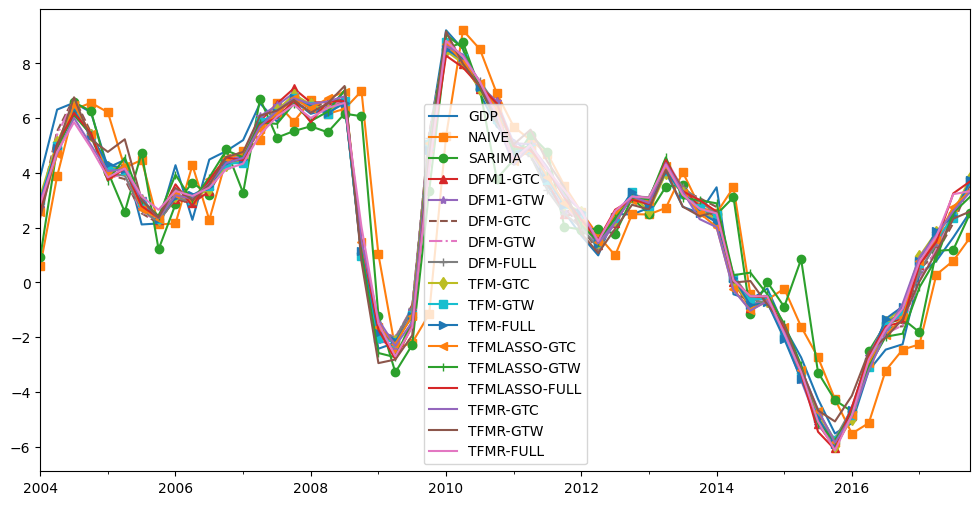

In [70]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['GDP'] = y_train
forecasts_insample['NAIVE'] = naive_train.values
forecasts_insample['SARIMA'] = pred_sarima_is.values
forecasts_insample['DFM1-GTC'] = dfm1gtc_pred
forecasts_insample['DFM1-GTW'] = dfm1gtw_pred
forecasts_insample['DFM-GTC'] = dfmgtc_pred
forecasts_insample['DFM-GTW'] = dfmgtw_pred
forecasts_insample['DFM-FULL'] = dfmfull_pred
forecasts_insample['TFM-GTC'] = tfmgtc_pred
forecasts_insample['TFM-GTW'] = tfmgtw_pred
forecasts_insample['TFM-FULL'] = tfmfull_pred
forecasts_insample['TFMLASSO-GTC'] = tfmlassogtc_pred
forecasts_insample['TFMLASSO-GTW'] = tfmlassogtw_pred
forecasts_insample['TFMLASSO-FULL'] = tfmlassofull_pred
forecasts_insample['TFMR-GTC'] = tfmrobustgtc_pred
forecasts_insample['TFMR-GTW'] = tfmrobustgtw_pred
forecasts_insample['TFMR-FULL'] = tfmrobustfull_pred


# ----

ax = forecasts_insample.plot(figsize=(12,6), style=['-', 's-','o-','^-', '*-','--','-.', '+-', 'd-', 's-', '>-','<-','|-'])

# plt.savefig('all-models-images/GTC-GTW-NEW-ALLMODELS-insample.png')

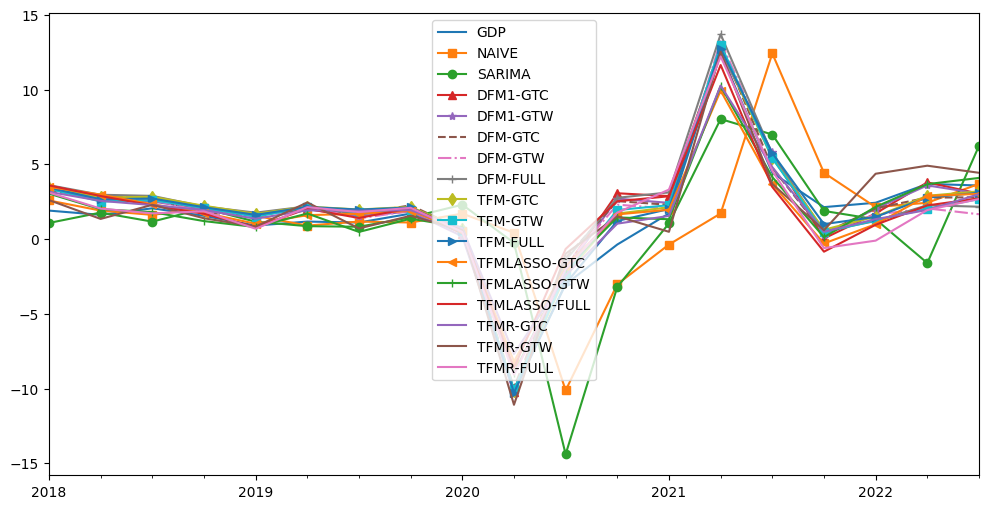

In [71]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['GDP'] = y_test
forecasts_outsample['NAIVE'] = naive_test.values
forecasts_outsample['SARIMA'] = pred_sarima_os
forecasts_outsample['DFM1-GTC'] = dfm1gtc_pred_os
forecasts_outsample['DFM1-GTW'] = dfm1gtw_pred_os
forecasts_outsample['DFM-GTC'] = dfmgtc_pred_os
forecasts_outsample['DFM-GTW'] = dfmgtw_pred_os
forecasts_outsample['DFM-FULL'] = dfmfull_pred_os
forecasts_outsample['TFM-GTC'] = tfmgtc_pred_os
forecasts_outsample['TFM-GTW'] = tfmgtw_pred_os
forecasts_outsample['TFM-FULL'] = tfmfull_pred_os
forecasts_outsample['TFMLASSO-GTC'] = tfmlassogtc_pred_os
forecasts_outsample['TFMLASSO-GTW'] = tfmlassogtw_pred_os
forecasts_outsample['TFMLASSO-FULL'] = tfmlassofull_pred_os
forecasts_outsample['TFMR-GTC'] = tfmrobustgtc_pred_os
forecasts_outsample['TFMR-GTW'] = tfmrobustgtw_pred_os
forecasts_outsample['TFMR-FULL'] = tfmrobustfull_pred_os


# ----

ax = forecasts_outsample.plot(figsize=(12,6), style=['-', 's-','o-','^-', '*-','--','-.', '+-', 'd-', 's-', '>-','<-','|-'])

# plt.savefig('all-models-images/GTC-GTW-NEW-ALLMODELS-insample.png')

# Métricas

In [72]:
# Naive 

# In-sample 
naive_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['NAIVE']))
naive_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['NAIVE'])
naive_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['NAIVE'])

# Out-of-sample
naive_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['NAIVE']))
naive_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['NAIVE'])
naive_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['NAIVE'])

# -----

# SARIMA(1,0,1)(0,0,2,4)
# In-sample
sarima_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['SARIMA']))
sarima_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['SARIMA'])
sarima_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['SARIMA'])

#Out-of-sample
sarima_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['SARIMA']))
sarima_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['SARIMA'])
sarima_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['SARIMA'])


# -----

# 1 fator GTC

# In-sample
dfm1gtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM1-GTC']))
dfm1gtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM1-GTC'])
dfm1gtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM1-GTC'])

#Out-of-sample
dfm1gtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM1-GTC']))
dfm1gtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM1-GTC'])
dfm1gtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM1-GTC'])

# ----


# 1 fator GTW

# In-sample
dfm1gtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM1-GTW']))
dfm1gtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM1-GTW'])
dfm1gtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM1-GTW'])

#Out-of-sample
dfm1gtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM1-GTW']))
dfm1gtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM1-GTW'])
dfm1gtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM1-GTW'])

# ----


# TODOS OS FATORES GTC

# In-sample
dfmgtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTC']))
dfmgtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTC'])
dfmgtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTC'])

#Out-of-sample
dfmgtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTC']))
dfmgtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTC'])
dfmgtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTC'])


# ----


# TODOS OS FATORES GTW

# In-sample
dfmgtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTW']))
dfmgtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTW'])
dfmgtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-GTW'])

#Out-of-sample
dfmgtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTW']))
dfmgtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTW'])
dfmgtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-GTW'])

# ---


# TODOS OS FATORES GTC+GTW

# In-sample
dfmfull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['DFM-FULL']))
dfmfull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['DFM-FULL'])
dfmfull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['DFM-FULL'])

#Out-of-sample
dfmfull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-FULL']))
dfmfull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-FULL'])
dfmfull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['DFM-FULL'])

# ---


# TFM P-VALOR GTC

# In-sample
tfmgtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTC']))
tfmgtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTC'])
tfmgtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTC'])

#Out-of-sample
tfmgtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTC']))
tfmgtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTC'])
tfmgtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTC'])

# ---


# TFM P-VALOR GTW

# In-sample
tfmgtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTW']))
tfmgtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTW'])
tfmgtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-GTW'])

#Out-of-sample
tfmgtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTW']))
tfmgtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTW'])
tfmgtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-GTW'])

# ---


# TFM P-VALOR GTC+GTW

# In-sample
tfmfull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFM-FULL']))
tfmfull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFM-FULL'])
tfmfull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFM-FULL'])

#Out-of-sample
tfmfull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-FULL']))
tfmfull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-FULL'])
tfmfull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFM-FULL'])

# ---


# TFMLASSO GTC

# In-sample
tfmlassogtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTC']))
tfmlassogtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTC'])
tfmlassogtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTC'])

#Out-of-sample
tfmlassogtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTC']))
tfmlassogtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTC'])
tfmlassogtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTC'])

# ---

# ---


# TFMLASSO GTW

# In-sample
tfmlassogtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTW']))
tfmlassogtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTW'])
tfmlassogtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-GTW'])

#Out-of-sample
tfmlassogtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTW']))
tfmlassogtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTW'])
tfmlassogtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-GTW'])

# ---


# TFMLASSO GTC+GTW

# In-sample
tfmlassofull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-FULL']))
tfmlassofull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-FULL'])
tfmlassofull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMLASSO-FULL'])

#Out-of-sample
tfmlassofull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-FULL']))
tfmlassofull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-FULL'])
tfmlassofull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMLASSO-FULL'])

# ---


# ---


# TFMR GTC

# In-sample
tfmrobustgtc_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTC']))
tfmrobustgtc_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTC'])
tfmrobustgtc_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTC'])

#Out-of-sample
tfmrobustgtc_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTC']))
tfmrobustgtc_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTC'])
tfmrobustgtc_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTC'])

# ---

# ---


# TFMR GTW

# In-sample
tfmrobustgtw_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTW']))
tfmrobustgtw_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTW'])
tfmrobustgtw_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-GTW'])

#Out-of-sample
tfmrobustgtw_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTW']))
tfmrobustgtw_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTW'])
tfmrobustgtw_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-GTW'])

# ---

# ---


# TFMR GTW

# In-sample
tfmrobustfull_rmse_is = np.sqrt(mean_squared_error(forecasts_insample['GDP'], forecasts_insample['TFMR-FULL']))
tfmrobustfull_mae_is = mean_absolute_error(forecasts_insample['GDP'], forecasts_insample['TFMR-FULL'])
tfmrobustfull_mape_is = mean_absolute_percentage_error(forecasts_insample['GDP'], forecasts_insample['TFMR-FULL'])

#Out-of-sample
tfmrobustfull_rmse_os = np.sqrt(mean_squared_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-FULL']))
tfmrobustfull_mae_os = mean_absolute_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-FULL'])
tfmrobustfull_mape_os = mean_absolute_percentage_error(forecasts_outsample['GDP'], forecasts_outsample['TFMR-FULL'])

# ---


In [73]:
# FINAL DF

# Definindo variáveis
method = ['NAIVE', 'SARIMA', 'DFM1-GTC', 'DFM1-GTW', 'DFM-GTC', 'DFM-GTW', 'DFM-FULL', 'TFM-GTC', 'TFM-GTW', 'TFM-FULL', 'TFMLASSO-GTC', 'TFMLASSO-GTW',
          'TFMLASSO-FULL', 'TFMR-GTC', 'TFMR-GTW', 'TFMR-FULL']

rmse_is = [naive_rmse_is, sarima_rmse_is, dfm1gtc_rmse_is, dfm1gtw_rmse_is, dfmgtc_rmse_is, dfmgtw_rmse_is, dfmfull_rmse_is, tfmgtc_rmse_is, tfmgtw_rmse_is,
           tfmfull_rmse_is, tfmlassogtc_rmse_is, tfmlassogtw_rmse_is, tfmlassofull_rmse_is, tfmrobustgtc_rmse_is, tfmrobustgtw_rmse_is, tfmrobustfull_rmse_is]

mae_is = [naive_mae_is, sarima_mae_is, dfm1gtc_mae_is, dfm1gtw_mae_is, dfmgtc_mae_is, dfmgtw_mae_is, dfmfull_mae_is, tfmgtc_mae_is, tfmgtw_mae_is,
           tfmfull_mae_is, tfmlassogtc_mae_is, tfmlassogtw_mae_is, tfmlassofull_mae_is, tfmrobustgtc_mae_is, tfmrobustgtw_mae_is, tfmrobustfull_mae_is]

mape_is = [naive_mape_is, sarima_mape_is, dfm1gtc_mape_is, dfm1gtw_mape_is, dfmgtc_mape_is, dfmgtw_mape_is, dfmfull_mape_is, tfmgtc_mape_is, tfmgtw_mape_is,
           tfmfull_mape_is, tfmlassogtc_mape_is, tfmlassogtw_mape_is, tfmlassofull_mape_is, tfmrobustgtc_mape_is, tfmrobustgtw_mape_is, tfmrobustfull_mape_is]

rmse_os = [naive_rmse_os, sarima_rmse_os, dfm1gtc_rmse_os, dfm1gtw_rmse_os, dfmgtc_rmse_os, dfmgtw_rmse_os, dfmfull_rmse_os, tfmgtc_rmse_os, tfmgtw_rmse_os,
           tfmfull_rmse_os, tfmlassogtc_rmse_os, tfmlassogtw_rmse_os, tfmlassofull_rmse_os, tfmrobustgtc_rmse_os, tfmrobustgtw_rmse_os, tfmrobustfull_rmse_os]

mae_os = [naive_mae_os, sarima_mae_os, dfm1gtc_mae_os, dfm1gtw_mae_os, dfmgtc_mae_os, dfmgtw_mae_os, dfmfull_mae_os, tfmgtc_mae_os, tfmgtw_mae_os,
           tfmfull_mae_os, tfmlassogtc_mae_os, tfmlassogtw_mae_os, tfmlassofull_mae_os, tfmrobustgtc_mae_os, tfmrobustgtw_mae_os, tfmrobustfull_mae_os]

mape_os = [naive_mape_os, sarima_mape_os, dfm1gtc_mape_os, dfm1gtw_mape_os, dfmgtc_mape_os, dfmgtw_mape_os, dfmfull_mape_os, tfmgtc_mape_os, tfmgtw_mape_os,
           tfmfull_mape_os, tfmlassogtc_mape_os, tfmlassogtw_mape_os, tfmlassofull_mape_os, tfmrobustgtc_mape_os, tfmrobustgtw_mape_os, tfmrobustfull_mape_os]


metrics_df = pd.DataFrame({'Method':method, 
                           'RMSE_IS': rmse_is,
                           'MAE_IS': mae_is,
                           'MAPE_IS': mape_is,
                           'RMSE_OOS': rmse_os,
                           'MAE_OOS': mae_os,
                           'MAPE_OOS': mape_os
                           })

metrics_df.set_index('Method', inplace = True)
metrics_df = metrics_df.round(3)
metrics_df

,RMSE_IS,MAE_IS,MAPE_IS,RMSE_OOS,MAE_OOS,MAPE_OOS
Method,,,,,,
NAIVE,1.890,1.336,0.796,4.363,2.620,1.136
SARIMA,1.431,1.048,0.676,3.993,2.439,1.224
DFM1-GTC,0.604,0.504,0.238,1.201,0.921,0.897
DFM1-GTW,0.614,0.503,0.229,1.061,0.773,0.790
DFM-GTC,0.511,0.424,0.186,1.096,0.871,0.801
DFM-GTW,0.534,0.442,0.209,1.179,0.955,0.754
DFM-FULL,0.602,0.490,0.231,1.331,1.138,0.915
TFM-GTC,0.623,0.510,0.274,0.952,0.818,0.709
TFM-GTW,0.567,0.460,0.234,1.042,0.876,0.710


In [74]:
metrics_oos = metrics_df[['RMSE_OOS', 'MAE_OOS', 'MAPE_OOS']].copy()
metrics_oos_share = metrics_oos.copy()
metrics_oos_share['RMSE'] = metrics_oos_share['RMSE_OOS'] / metrics_oos_share['RMSE_OOS'].loc['SARIMA']
metrics_oos_share['MAE'] = metrics_oos_share['MAE_OOS'] / metrics_oos_share['MAE_OOS'].loc['SARIMA']
metrics_oos_share['MAPE'] = metrics_oos_share['MAPE_OOS'] / metrics_oos_share['MAPE_OOS'].loc['SARIMA']
metrics_oos_share.drop(['RMSE_OOS', 'MAE_OOS', 'MAPE_OOS'], axis = 1, inplace = True)
metrics_oos_share.drop('SARIMA', axis = 0, inplace=True)
metrics_oos_share.round(3)

,RMSE,MAE,MAPE
Method,,,
NAIVE,1.093,1.074,0.928
DFM1-GTC,0.301,0.378,0.733
DFM1-GTW,0.266,0.317,0.645
DFM-GTC,0.274,0.357,0.654
DFM-GTW,0.295,0.392,0.616
DFM-FULL,0.333,0.467,0.748
TFM-GTC,0.238,0.335,0.579
TFM-GTW,0.261,0.359,0.580
TFM-FULL,0.217,0.303,0.480


In [75]:
print(metrics_oos_share.round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   RMSE &    MAE &   MAPE \\
Method        &        &        &        \\
\midrule
NAIVE         &  1.093 &  1.074 &  0.928 \\
DFM1-GTC      &  0.301 &  0.378 &  0.733 \\
DFM1-GTW      &  0.266 &  0.317 &  0.645 \\
DFM-GTC       &  0.274 &  0.357 &  0.654 \\
DFM-GTW       &  0.295 &  0.392 &  0.616 \\
DFM-FULL      &  0.333 &  0.467 &  0.748 \\
TFM-GTC       &  0.238 &  0.335 &  0.579 \\
TFM-GTW       &  0.261 &  0.359 &  0.580 \\
TFM-FULL      &  0.217 &  0.303 &  0.480 \\
TFMLASSO-GTC  &  0.314 &  0.404 &  0.521 \\
TFMLASSO-GTW  &  0.241 &  0.296 &  0.450 \\
TFMLASSO-FULL &  0.356 &  0.462 &  0.687 \\
TFMR-GTC      &  0.284 &  0.378 &  0.463 \\
TFMR-GTW      &  0.267 &  0.344 &  0.502 \\
TFMR-FULL     &  0.318 &  0.402 &  0.585 \\
\bottomrule
\end{tabular}



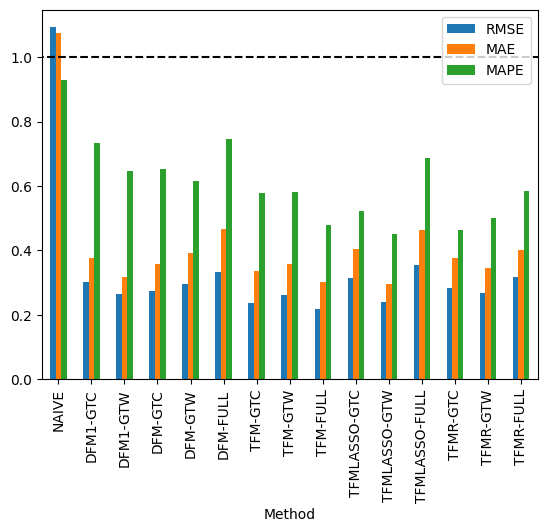

In [76]:
ax = metrics_oos_share.plot.bar(rot = 90)
ax.hlines(y = 1, xmin = -1, xmax = metrics_oos_share.shape[0], colors = 'black', linestyles = 'dashed')
plt.savefig('all-models-images/GTCGTW-ALLMODELS-performance-share.png')